This project aims to analyze customer churn in The Look E-Commerce. The data used in this project is data that comes from [Big Query](https://console.cloud.google.com/bigquery) which can be retrieved with [this Query](https://docs.google.com/document/d/1m15eotFnkg5T_ekqvNQdarrXrNeryPAnA8Rqs-BXv_I/edit?usp=sharing).


The background of this project is due to a large number of lost and almost lost customers in the look e-commerce from the segmentation results using [RFM](https://medium.com/@dinichandraa/the-look-e-commerce-customer-segmentation-a45de7d44b20). For further analysis, we can do churn analysis in the form of **labeling churn**, seeing the causes of churn, and also making **predictions analysis** for proactive actions for e-commerce in order to be able to retain its customers.

# Library & Data Load

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BI Bootcamp/Talent Showcase/new/TheLook_Dataset_of2022.csv')

# Data Quick Look

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54979 entries, 0 to 54978
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     54979 non-null  int64  
 1   order_id    54979 non-null  int64  
 2   quantity    54979 non-null  int64  
 3   created_at  54979 non-null  object 
 4   price       54979 non-null  float64
 5   category    54979 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ MB


In [ ]:
df.head(2)

,user_id,order_id,quantity,created_at,price,category
0,47541,59578,1,2022-01-31 00:16:00 UTC,11.99,Plus
1,93382,116667,1,2022-01-31 00:19:00 UTC,145.00,Jeans


In [ ]:
df.tail(2)

,user_id,order_id,quantity,created_at,price,category
54977,18454,23027,1,2022-12-31 18:31:00 UTC,31.900000,Fashion Hoodies & Sweatshirts
54978,55360,69348,1,2022-12-31 18:57:00 UTC,98.080002,Blazers & Jackets


In [ ]:
df.describe()

,user_id,order_id,quantity,price
count,54979.000000,54979.000000,54979.000000,54979.000000
mean,49807.272395,62277.696539,1.667782,59.688185
std,28809.347387,36036.041841,0.965586,65.330898
min,5.000000,8.000000,1.000000,0.020000
25%,25027.500000,31166.500000,1.000000,24.500000
50%,49295.000000,61756.000000,1.000000,39.990002
75%,74748.000000,93528.000000,2.000000,69.949997
max,100000.000000,124855.000000,4.000000,999.000000


In [ ]:
df.shape

(54979, 6)

There are 54937 rows and 6 columns on this dataset

# Data Cleaning

## Missing Value

In [ ]:
df.isnull().sum()

user_id       0
order_id      0
quantity      0
created_at    0
price         0
category      0
dtype: int64

there's not a single missing value spotted on this data set, so we can continue on to the next step

## Duplicate

In [ ]:
df.duplicated().sum()

42

there are 42 duplicate rows, we should remove it  

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54937 entries, 0 to 54978
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     54937 non-null  int64  
 1   order_id    54937 non-null  int64  
 2   quantity    54937 non-null  int64  
 3   created_at  54937 non-null  object 
 4   price       54937 non-null  float64
 5   category    54937 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.9+ MB


now our data have 54937 rows

# Data Prepare

Since this dataset does not contain a churn label, we need to label it first, so we need to prepare the data and also set up the churn criteria.

## Change Data Type

The `created_at` data in this dataset has data type **object**, because we need it for future analysis, we need to change it to **datetime**.

In [ ]:
df['created_at'] = df['created_at'].str.replace('UTC','')

Because the data has an object type and the system cannot identify 'UTC' as a datetime, so we need to remove it first.

In [ ]:
df['created_at'] = df['created_at'].str[:10]

we only need the date data, then we can slice it on the data that only contains date information

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])

## Create Month Column

In [ ]:
# extract the month name from datetime data
df['month'] = pd.DatetimeIndex(df['created_at']).month

In [ ]:
df['month'] = df['created_at'].dt.month_name()

In [ ]:
df

,user_id,order_id,quantity,created_at,price,category,month
0,47541,59578,1,2022-01-31,11.990000,Plus,January
1,93382,116667,1,2022-01-31,145.000000,Jeans,January
2,93382,116667,1,2022-01-31,10.380000,Tops & Tees,January
3,24219,30151,1,2022-01-31,56.000000,Jeans,January
4,24219,30151,1,2022-01-31,24.990000,Shorts,January
...,...,...,...,...,...,...,...
54974,6655,8227,1,2022-12-31,7.990000,Tops & Tees,December
54975,95817,119646,1,2022-12-31,50.000000,Fashion Hoodies & Sweatshirts,December
54976,26138,32551,1,2022-12-31,17.000000,Underwear,December
54977,18454,23027,1,2022-12-31,31.900000,Fashion Hoodies & Sweatshirts,December


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54937 entries, 0 to 54978
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     54937 non-null  int64         
 1   order_id    54937 non-null  int64         
 2   quantity    54937 non-null  int64         
 3   created_at  54937 non-null  datetime64[ns]
 4   price       54937 non-null  float64       
 5   category    54937 non-null  object        
 6   month       54937 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [ ]:
df['created_at'] = df['created_at'].dt.date

In [ ]:
import datetime as dt
NOW = dt.date(2022,12,31)

We need to define `NOW` or the last day of recorded sales which is used to see how many days the customer has not repurchased since the last date of sale in e-commerce and the last date the customer made a purchase.

## Create Total Spend Column

In [ ]:
df['total_spend'] = df['quantity']*df['price']

In [ ]:
df.head(2)

,user_id,order_id,quantity,created_at,price,category,month,total_spend
0,47541,59578,1,2022-01-31,11.99,Plus,January,11.99
1,93382,116667,1,2022-01-31,145.00,Jeans,January,145.00


# Churn Customer

To do labeling of Churn customers, we need to aggregate the data based on the customer's user id.

## Aggregate & Grouping by User ID

In [ ]:
#aggregate the data based on customer id
df2 = df.groupby('user_id').agg({'created_at': lambda x: (NOW - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'total_spend': lambda x: x.sum(),
                                        'month': lambda x: x.nunique()}) # Monetary Value

df2['created_at'] = df2['created_at'].astype(int)
df2.rename(columns={'created_at': 'recency', 'order_id': 'frequency', 'month': 'active_month'}, inplace=True)

In [ ]:
df2.describe()

,recency,frequency,total_spend,active_month
count,20009.000000,20009.000000,20009.000000,20009.000000
mean,123.603279,2.745614,273.000990,1.397271
std,94.975754,2.811529,450.790722,0.665866
min,0.000000,1.000000,0.020000,1.000000
25%,40.000000,1.000000,45.000000,1.000000
50%,103.000000,2.000000,112.900002,1.000000
75%,196.000000,3.000000,297.240000,2.000000
max,334.000000,32.000000,6497.940033,4.000000


We have to check the correctness of this table first, so let's do the check!

In [ ]:
df2

,recency,frequency,total_spend,active_month
user_id,,,,
5,241,1,97.000000,1
18,43,1,12.990000,1
25,104,1,44.250000,1
26,99,1,38.500000,1
27,239,1,25.000000,1
...,...,...,...,...
99973,176,6,479.910009,2
99977,262,2,428.000000,1
99986,66,4,315.000000,2


In [ ]:
df[df['user_id']==99986]

,user_id,order_id,quantity,created_at,price,category,month,total_spend
27381,99986,124841,1,2022-08-27,36.0,Intimates,August,36.0
27382,99986,124841,1,2022-08-27,69.0,Fashion Hoodies & Sweatshirts,August,69.0
38490,99986,124840,2,2022-10-26,36.0,Intimates,October,72.0
38491,99986,124840,2,2022-10-26,69.0,Fashion Hoodies & Sweatshirts,October,138.0


In [ ]:
(NOW - dt.date(2022,10,26)).days==66

True

Ok, our table is already correct!!

## Labeling Churn Customer

I define the Churn customer is when the customer not make repurchase more than **6 month** (180days)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20009 entries, 5 to 100000
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recency       20009 non-null  int64  
 1   frequency     20009 non-null  int64  
 2   total_spend   20009 non-null  float64
 3   active_month  20009 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 781.6 KB


In [ ]:
def segment(R):
    if R > 180:
      return 'Yes'
    else:
      return 'No'

df2['Churn'] = df2['recency'].apply(segment)

In [ ]:
df2

,recency,frequency,total_spend,active_month,Churn
user_id,,,,,
5,241,1,97.000000,1,Yes
18,43,1,12.990000,1,No
25,104,1,44.250000,1,No
26,99,1,38.500000,1,No
27,239,1,25.000000,1,Yes
...,...,...,...,...,...
99973,176,6,479.910009,2,No
99977,262,2,428.000000,1,Yes
99986,66,4,315.000000,2,No


In [ ]:
df_rfm = df2.reset_index()

In [ ]:
df_rfm.head()

,user_id,recency,frequency,total_spend,active_month,Churn
0,5,241,1,97.00,1,Yes
1,18,43,1,12.99,1,No
2,25,104,1,44.25,1,No
3,26,99,1,38.50,1,No
4,27,239,1,25.00,1,Yes


In [ ]:
df_rfm.tail()

,user_id,recency,frequency,total_spend,active_month,Churn
20004,99973,176,6,479.910009,2,No
20005,99977,262,2,428.000000,1,Yes
20006,99986,66,4,315.000000,2,No
20007,99994,43,2,123.279999,1,No
20008,100000,288,2,343.980003,1,Yes


ada sekitar 20000 customer selama tahun 2022

In [ ]:
df_rfm['user_id'].value_counts().sort_index()

5         1
18        1
25        1
26        1
27        1
         ..
99973     1
99977     1
99986     1
99994     1
100000    1
Name: user_id, Length: 20009, dtype: int64



---



# **Churn Prediction**



---



# Load Library

In [ ]:
!pip install dalex
!pip install scikit-plot
!pip install xgboost
!pip install feature_engine
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
# load numpy untuk manipulasi vektor
import numpy as np
# load matplotlib untuk visualisasi data
import matplotlib.pyplot as plt
# load seaborn untuk visualisasi data
import seaborn as sns

# load metrics object dari sklearn
from sklearn import metrics
# load train-test data splitter
from sklearn.model_selection import train_test_split
# load Decision Tree classifier model
from sklearn.tree import DecisionTreeClassifier
# load Random Forest classifier model
from sklearn.ensemble import RandomForestClassifier
# load SVM classifier model
from sklearn.svm import SVC
# load KNN classifier model
from sklearn.neighbors import KNeighborsClassifier
# load LogReg classifier model
from sklearn.linear_model import LogisticRegression
# load xgboost classifier model
from xgboost import XGBClassifier

# Load DALEX untuk interpretability
import dalex as dx

# load scikitplot untuk visualisasi metrik
import scikitplot as skplt
from scikitplot.metrics import plot_roc_curve

%matplotlib inline

# for Q-Q plots
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from scipy.stats import chi2_contingency

#Confusion Matrix
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Output hidden; open in https://colab.research.google.com to view.

# Import initial data

we need to join other datasets to add variables that will be used to help make predictions. This dataset is also taken from BigQuery with the [Query this](https://docs.google.com/document/d/1KwvPLfteadaEaptfq2yCaGgaK4QMHUPKR066-RhT_E8/edit?usp=share_link). 

The limitation on the query results is due to the ability with the increasing amount of data taken and processed, the computational ability will be heavy.

In [ ]:
data_customers = pd.read_csv('/content/drive/MyDrive/BI Bootcamp/Talent Showcase/new/750data_churn_customer.csv')

In [ ]:
# Merge the dataset based on user_id
df_churn = data_customers.merge(df_rfm, on='user_id', how='inner')

In [ ]:
df_churn[df_churn['user_id']==69384]

,user_id,gender,age,source,quantity,created_at,price,browser,event_type,recency,frequency,total_spend,active_month,Churn
0,69384,M,34,Organic,1,2022-01-01 00:33:00 UTC,25.000000,Chrome,cart,282,1,160.0,1,Yes
1,69384,M,34,Email,1,2022-01-01 00:33:00 UTC,99.989998,Chrome,product,282,1,160.0,1,Yes
2,69384,M,34,Organic,1,2022-01-01 00:33:00 UTC,36.990002,Chrome,department,282,1,160.0,1,Yes
3,69384,M,34,Email,1,2022-01-01 00:33:00 UTC,36.990002,Chrome,department,282,1,160.0,1,Yes
4,69384,M,34,Adwords,1,2022-01-01 00:33:00 UTC,44.500000,Firefox,cart,282,1,160.0,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,69384,M,34,Email,1,2022-01-01 00:33:00 UTC,36.990002,Chrome,cart,282,1,160.0,1,Yes
224,69384,M,34,Organic,1,2022-01-01 00:33:00 UTC,44.500000,Chrome,product,282,1,160.0,1,Yes
225,69384,M,34,Organic,1,2022-01-01 00:33:00 UTC,44.500000,Chrome,department,282,1,160.0,1,Yes
226,69384,M,34,Organic,1,2022-01-01 00:33:00 UTC,44.500000,Chrome,department,282,1,160.0,1,Yes


It can be noticed that one user id can have more than one transaction row. This is what machine learning will learn later in predicting churn based on the behavior of each transaction made by each user_id.

## Data Cleaning

**Missing Value**

In [ ]:
df_churn.isna().sum()

user_id         0
gender          0
age             0
source          0
quantity        0
created_at      0
price           0
browser         0
event_type      0
recency         0
frequency       0
total_spend     0
active_month    0
Churn           0
dtype: int64

**Duplicate**

In [ ]:
print('Before drop duplicated : ', df_churn.shape)

Before drop duplicated :  (148058, 14)


In [ ]:
df_churn = df_churn.drop_duplicates()

In [ ]:
print('After drop duplicated : ', df_churn.shape)

After drop duplicated :  (68217, 14)


## Data Preparation

In [ ]:
df_churn['user_id'].value_counts()

13315    540
26382    540
5833     520
80637    450
2043     396
        ... 
82575      5
92680      5
66112      5
14963      5
44467      5
Name: user_id, Length: 1950, dtype: int64

In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68217 entries, 0 to 148046
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       68217 non-null  int64  
 1   gender        68217 non-null  object 
 2   age           68217 non-null  int64  
 3   source        68217 non-null  object 
 4   quantity      68217 non-null  int64  
 5   created_at    68217 non-null  object 
 6   price         68217 non-null  float64
 7   browser       68217 non-null  object 
 8   event_type    68217 non-null  object 
 9   recency       68217 non-null  int64  
 10  frequency     68217 non-null  int64  
 11  total_spend   68217 non-null  float64
 12  active_month  68217 non-null  int64  
 13  Churn         68217 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 7.8+ MB


In [ ]:
df_churn['created_at'] = df_churn['created_at'].str.replace('UTC','')

In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68217 entries, 0 to 148046
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       68217 non-null  int64  
 1   gender        68217 non-null  object 
 2   age           68217 non-null  int64  
 3   source        68217 non-null  object 
 4   quantity      68217 non-null  int64  
 5   created_at    68217 non-null  object 
 6   price         68217 non-null  float64
 7   browser       68217 non-null  object 
 8   event_type    68217 non-null  object 
 9   recency       68217 non-null  int64  
 10  frequency     68217 non-null  int64  
 11  total_spend   68217 non-null  float64
 12  active_month  68217 non-null  int64  
 13  Churn         68217 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 7.8+ MB


In [ ]:
df_churn['created_at'] = df_churn['created_at'].str[:10]

In [ ]:
df_churn['created_at'] = pd.to_datetime(df_churn['created_at'])
df_churn['day'] = pd.DatetimeIndex(df_churn['created_at']).day
df_churn['day'] = df_churn['created_at'].dt.day_name()

In [ ]:
df_churn['month'] = df_churn['created_at'].dt.month_name()

In [ ]:
df_churn.head()

,user_id,gender,age,source,quantity,created_at,price,browser,event_type,recency,frequency,total_spend,active_month,Churn,day,month
0,69384,M,34,Organic,1,2022-01-01,25.000000,Chrome,cart,282,1,160.0,1,Yes,Saturday,January
1,69384,M,34,Email,1,2022-01-01,99.989998,Chrome,product,282,1,160.0,1,Yes,Saturday,January
2,69384,M,34,Organic,1,2022-01-01,36.990002,Chrome,department,282,1,160.0,1,Yes,Saturday,January
3,69384,M,34,Email,1,2022-01-01,36.990002,Chrome,department,282,1,160.0,1,Yes,Saturday,January
4,69384,M,34,Adwords,1,2022-01-01,44.500000,Firefox,cart,282,1,160.0,1,Yes,Saturday,January


# Data Exploration

In [ ]:
df_churn.columns

Index(['user_id', 'gender', 'age', 'source', 'quantity', 'created_at', 'price',
       'browser', 'event_type', 'recency', 'frequency', 'total_spend',
       'active_month', 'Churn', 'day', 'month'],
      dtype='object')

## Check Target Distribution

In [ ]:
# Drop user id
df_drop = df_churn.copy()
df_drop.drop(['user_id'],axis = 1,inplace = True)
df_drop.head()

,gender,age,source,quantity,created_at,price,browser,event_type,recency,frequency,total_spend,active_month,Churn,day,month
0,M,34,Organic,1,2022-01-01,25.000000,Chrome,cart,282,1,160.0,1,Yes,Saturday,January
1,M,34,Email,1,2022-01-01,99.989998,Chrome,product,282,1,160.0,1,Yes,Saturday,January
2,M,34,Organic,1,2022-01-01,36.990002,Chrome,department,282,1,160.0,1,Yes,Saturday,January
3,M,34,Email,1,2022-01-01,36.990002,Chrome,department,282,1,160.0,1,Yes,Saturday,January
4,M,34,Adwords,1,2022-01-01,44.500000,Firefox,cart,282,1,160.0,1,Yes,Saturday,January


In [ ]:
# Cek perbandingan target
target = df_drop['Churn'].value_counts(normalize=True)

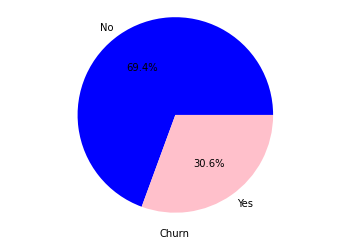

In [ ]:
species = target.index
count = target.values
colors= ['blue','pink']

plt.pie(count, labels=species,
        colors=colors, 
        autopct='%1.1f%%')
plt.xlabel('Churn')
plt.axis('equal')
plt.show()

69.4% of customers do not churn

30.6% of customers do churn

## Descriptive Statistic

**Numerical Column**

In [ ]:
#numericals columns
num_col = list(df_drop._get_numeric_data().columns)
print(num_col)

['age', 'quantity', 'price', 'recency', 'frequency', 'total_spend', 'active_month']


In [ ]:
# numerical statistical sumary
df_drop[num_col].describe()

,age,quantity,price,recency,frequency,total_spend,active_month
count,68217.000000,68217.000000,68217.000000,68217.000000,68217.000000,68217.000000,68217.000000
mean,40.675697,1.725010,58.486755,127.077898,2.674304,250.389743,1.384757
std,16.442541,1.040226,59.849610,96.873487,2.941944,394.426870,0.647503
min,12.000000,1.000000,1.750000,0.000000,1.000000,1.720000,1.000000
25%,27.000000,1.000000,24.950001,43.000000,1.000000,47.000000,1.000000
50%,40.000000,1.000000,39.990002,104.000000,2.000000,117.980000,1.000000
75%,55.000000,2.000000,69.500000,200.000000,3.000000,295.980000,2.000000
max,70.000000,4.000000,903.000000,334.000000,28.000000,4681.269997,4.000000


## Categorical Variable

In [ ]:
#categoricals columns
cat_col = [i for i in df_drop.columns if i not in num_col]
print(cat_col)

['gender', 'source', 'created_at', 'browser', 'event_type', 'Churn', 'day', 'month']


In [ ]:
# showing the precise value counts
# this code is especially useful if we have many categorical columns
for col in cat_col:
  print(f"Value counts of {col} column")
  print(df_drop[col].value_counts(), '\n')

Value counts of gender column
M    34623
F    33594
Name: gender, dtype: int64 

Value counts of source column
Email       28567
Adwords     20500
YouTube      7613
Facebook     7353
Organic      4184
Name: source, dtype: int64 

Value counts of created_at column
2022-03-16    815
2022-06-23    733
2022-06-10    721
2022-06-30    706
2022-02-25    696
             ... 
2022-03-08    130
2022-02-18    129
2022-01-23    114
2022-03-01    104
2022-05-02     87
Name: created_at, Length: 185, dtype: int64 

Value counts of browser column
Chrome     30454
Safari     15271
Firefox    14515
IE          4567
Other       3410
Name: browser, dtype: int64 

Value counts of event_type column
cart          15319
department    15319
product       15318
purchase      15315
home           6946
Name: event_type, dtype: int64 

Value counts of Churn column
No     47346
Yes    20871
Name: Churn, dtype: int64 

Value counts of day column
Thursday     10308
Tuesday      10195
Monday        9830
Wednesday   

### Gender

In [ ]:
df_churn['gender'].value_counts()

M    34623
F    33594
Name: gender, dtype: int64

### Source

In [ ]:
source_counts = df_churn['source'].value_counts()

In [ ]:
fig = px.bar(source_counts, title="Source Distribution")
fig.update_layout(
    xaxis_title = "Source",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

### Browser

In [ ]:
browser_counts = df_churn['browser'].value_counts()

In [ ]:
fig = px.bar(browser_counts, title="Browse Distribution")
fig.update_layout(
    xaxis_title = "Browser",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

### Event Type

In [ ]:
event_counts = df_churn['event_type'].value_counts()

In [ ]:
fig = px.bar(event_counts, title="Event Type Distribution")
fig.update_layout(
    xaxis_title = "Event Type",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

### Day

In [ ]:
days_counts = df_churn['day'].value_counts()

In [ ]:
fig = px.bar(days_counts, title="Day Distribution")
fig.update_layout(
    xaxis_title = "Day",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

### Month

In [ ]:
month_counts = df_churn['month'].value_counts()

In [ ]:
fig = px.bar(month_counts, title="Month Distribution")
fig.update_layout(
    xaxis_title = "Month Type",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

### Churn 

In [ ]:
churn_counts = df_churn['Churn'].value_counts()

In [ ]:
fig = px.bar(churn_counts, title="Churn Distribution")
fig.update_layout(
    xaxis_title = "Churn Type",
    yaxis_title = "Frequency",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

## Numerical Variable

### Age

In [ ]:
age_counts = df_churn['age'].value_counts()

In [ ]:
fig = px.bar(age_counts, title="Age Distribution") 
fig.update_layout( xaxis_title = "Age", yaxis_title = "Frequency", title_x = 0.5, showlegend = False ) 
fig.show()

### Active Month

In [ ]:
activemonth_counts = df_churn['active_month'].value_counts()

In [ ]:
fig = px.bar(activemonth_counts, title="Active Month Distribution") 
fig.update_layout( xaxis_title = "Active Month", yaxis_title = "Frequency", title_x = 0.5, showlegend = False ) 
fig.show()

### Data Date

In the query that has been formed, the data is filtered for the year 2022 only, but because the number of rows is very large and it is not possible to process it due to device capabilities, the query is limited to 750,000 rows only, but we do not know how long the data was retrieved. Then we have to check the lower and upper limits of the transaction date.

In [ ]:
df_churn['created_at'].min()

Timestamp('2022-01-01 00:00:00')

In [ ]:
df_churn['created_at'].max()

Timestamp('2022-07-04 00:00:00')

This data is taken from January to July 2022

## Categorical Data with Churn

In [ ]:
df_churn.columns

Index(['user_id', 'gender', 'age', 'source', 'quantity', 'created_at', 'price',
       'browser', 'event_type', 'recency', 'frequency', 'total_spend',
       'active_month', 'Churn', 'day', 'month'],
      dtype='object')

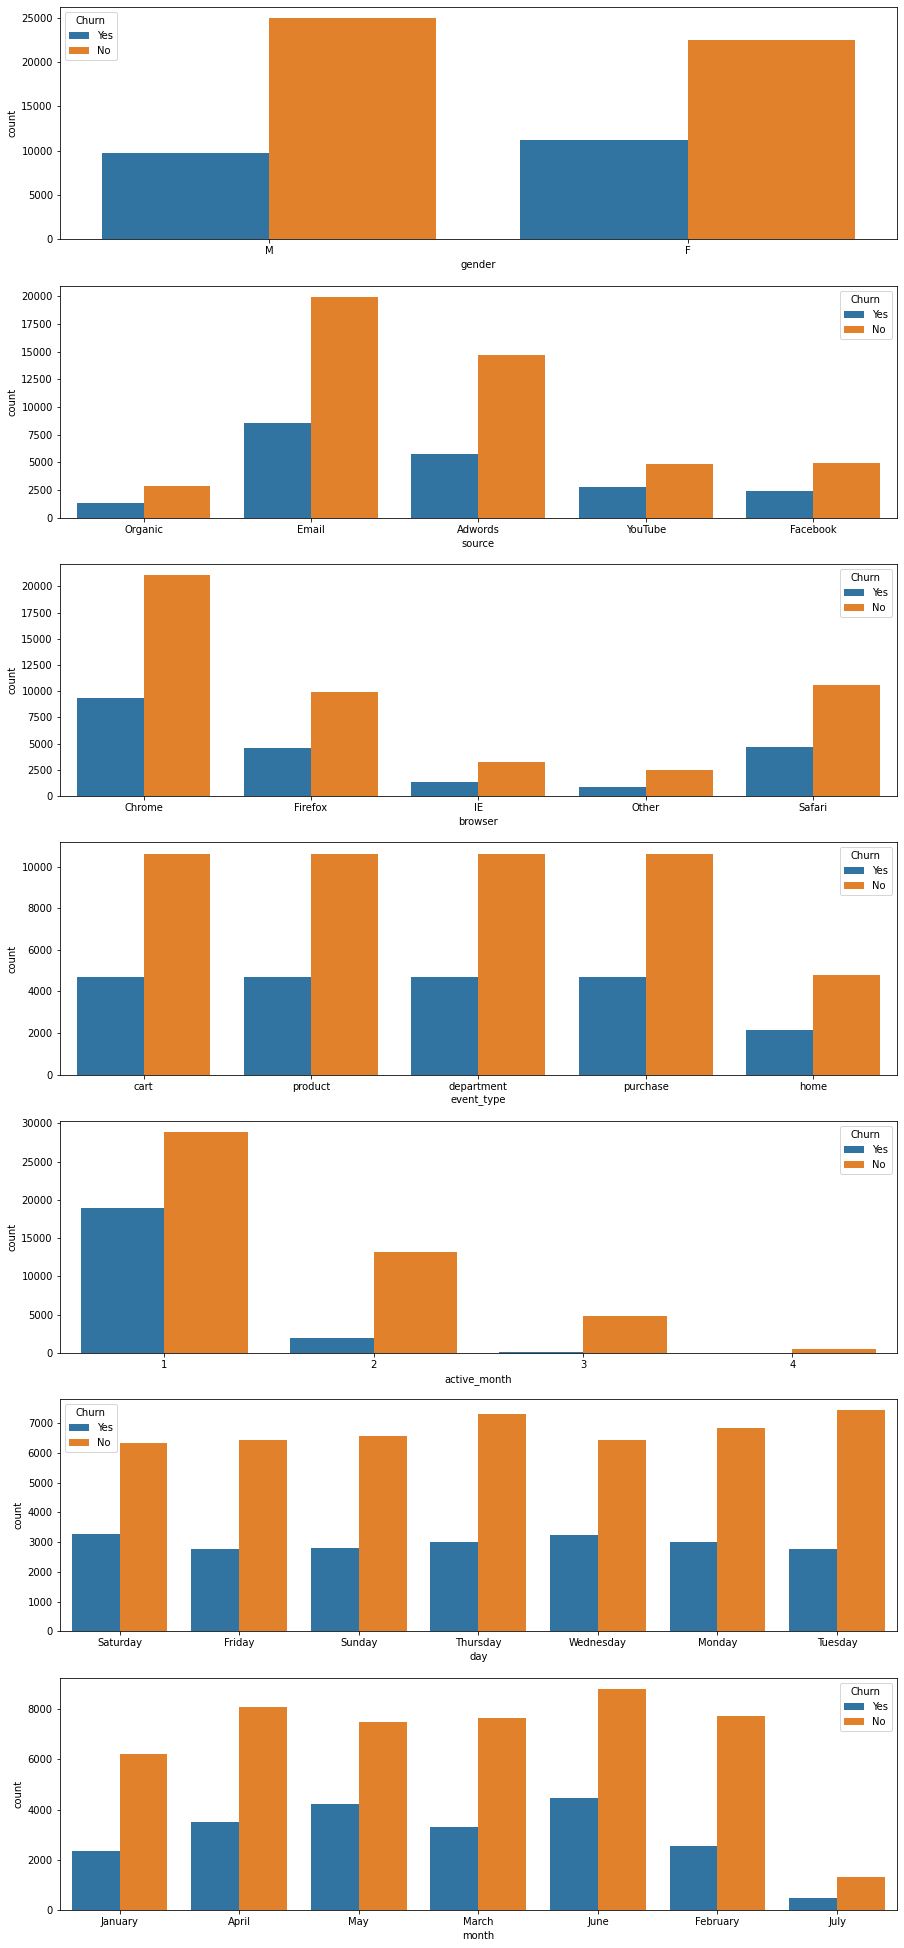

In [ ]:
# Definisikan fungsi untuk menghitung proporsi kategorikal
# list variable kategorikal
cat_var =['gender', 'source', 'browser', 'event_type', 'active_month', 'day', 'month']

fig, axes = plt.subplots(7, 1, figsize=(15, 35))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(cat, data=df_churn, hue="Churn", ax=ax)

## Numerical with Churn

**Quantity**

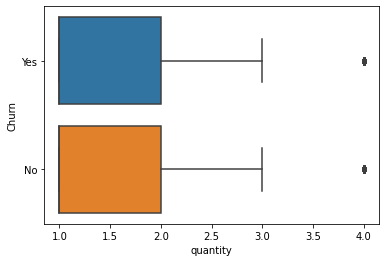

In [ ]:
sns.boxplot(data=df_churn, x='quantity', y= 'Churn')

**Price**

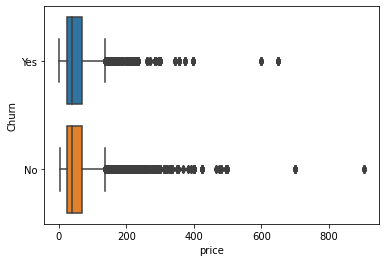

In [ ]:
sns.boxplot(data=df_churn, x='price', y="Churn")

**Frequency**

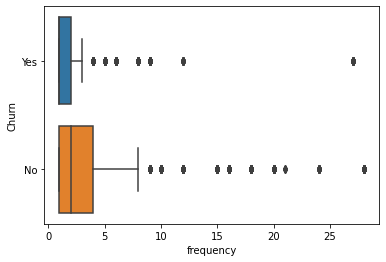

In [ ]:
sns.boxplot(data=df_churn, x='frequency', y="Churn")

**Total Spend**

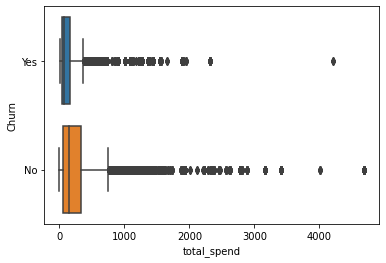

In [ ]:
sns.boxplot(data=df_churn, x='total_spend', y="Churn")

Before we jump on to feature engineering we need to drop columns that we dont use on mechine learning

In [ ]:
df_churn.drop(columns=['user_id','created_at','recency'],inplace=True)

In [ ]:
df_churn.head(2)

,gender,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,Churn,day,month
0,M,34,Organic,1,25.000000,Chrome,cart,1,160.0,1,Yes,Saturday,January
1,M,34,Email,1,99.989998,Chrome,product,1,160.0,1,Yes,Saturday,January


# Feature Engineering

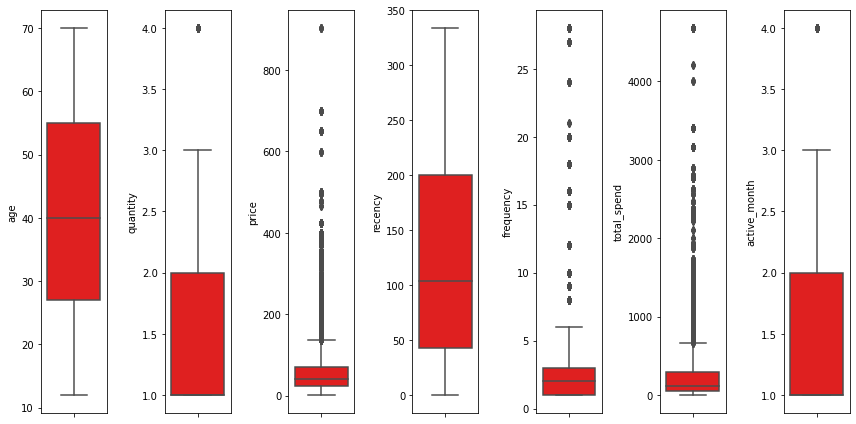

In [ ]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = num_col
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df_drop[features[i]], color='red')
    plt.tight_layout()

## Encoding

In [ ]:
df_churn.head()

,gender,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,Churn,day,month
0,M,34,Organic,1,25.000000,Chrome,cart,1,160.0,1,Yes,Saturday,January
1,M,34,Email,1,99.989998,Chrome,product,1,160.0,1,Yes,Saturday,January
2,M,34,Organic,1,36.990002,Chrome,department,1,160.0,1,Yes,Saturday,January
3,M,34,Email,1,36.990002,Chrome,department,1,160.0,1,Yes,Saturday,January
4,M,34,Adwords,1,44.500000,Firefox,cart,1,160.0,1,Yes,Saturday,January


In [ ]:
#categorical column
cat_col = [i for i in df_churn.columns if i not in num_col]

In [ ]:
for column in cat_col:
    print(f"============= {column} =================")
    display(df_churn[column].value_counts())
    print()

============= gender =================


M    34623
F    33594
Name: gender, dtype: int64


============= source =================


Email       28567
Adwords     20500
YouTube      7613
Facebook     7353
Organic      4184
Name: source, dtype: int64


============= browser =================


Chrome     30454
Safari     15271
Firefox    14515
IE          4567
Other       3410
Name: browser, dtype: int64


============= event_type =================


cart          15319
department    15319
product       15318
purchase      15315
home           6946
Name: event_type, dtype: int64


============= Churn =================


No     47346
Yes    20871
Name: Churn, dtype: int64


============= day =================


Thursday     10308
Tuesday      10195
Monday        9830
Wednesday     9688
Saturday      9609
Sunday        9366
Friday        9221
Name: day, dtype: int64


============= month =================


June        13295
May         11736
April       11603
March       10967
February    10257
January      8590
July         1769
Name: month, dtype: int64

Encoding is applied so the categorical data can be transformed into numerical data for machine learning.

- target data -> mapping encoding
- categorical data that has no level -> frequent encoding
- gender data -> One Hot Encoding (because it only has 2 categories)

### Mapping Encoding

In [ ]:
#Dictionary encoding
#label encoding
def dictionary_encoding(df_train):
    df_train = df_train.copy()
    
  #encoding requirement adjusting the ordinal -> column with positive and negative meaning is clear
    mapping_dictionary = {"Churn" :{"Yes" : 1 ,"No":0}
                         }
    
    df_train.replace(mapping_dictionary , inplace=True)
    
    return df_train

In [ ]:
df_churn = dictionary_encoding(df_churn)

### Frequent Encoding

before we do the frequent encoding, we need to split the data first

In [ ]:
# load train-test data splitter -> splitting
from sklearn.model_selection import train_test_split

feature = df_churn.drop(columns = 'Churn') #for including categorical
target = df_churn[['Churn']]



X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)


In [ ]:
#Function Frequent Encoding
def freq_encoding(df_train, df_test, col_to_count):
    
    # make a temporary copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()
    
    for col in col_to_count:
        # make the dictionary mapping label to counts
        X_frequency_map = df_train_temp[col].value_counts().to_dict()
        
        # remap the labels to their counts
        df_train_temp[col] = df_train_temp[col].map(X_frequency_map)
        df_test_temp[col] = df_test_temp[col].map(X_frequency_map)
    
    return df_train_temp, df_test_temp

In [ ]:
col_use = ['source','browser','day','month','event_type']
X_train, X_test = freq_encoding(X_train, X_test, col_use)

In [ ]:
X_train.head()

,gender,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,day,month
20784,M,67,16431,3,14.970000,24286,12207,3,241.439999,1,7900,6916
74470,M,56,5866,1,160.000000,24286,12273,1,129.990005,1,8269,8806
137095,F,15,22812,1,18.680000,2733,12207,1,25.000000,1,7663,10600
133216,F,12,6100,2,21.990000,24286,12207,2,24.000000,2,7403,10600
140162,M,44,22812,2,59.939999,12211,12207,4,139.810000,1,8034,10600


### OHE

OHE for columns that just have less than or equal to 3 or 4 categories

In [ ]:
# ========== One Hot Encoding ==========
def OHE(df_train, df_test, col_except_ohe, col_ohe):

    df_train = pd.concat(
        [df_train[col_except_ohe],
         pd.get_dummies(df_train[col_ohe])],
        axis=1)
    
    df_test = pd.concat(
        [df_test[col_except_ohe],
         pd.get_dummies(df_test[col_ohe])],
        axis=1)

    return df_train, df_test

In [ ]:
list_col = df_churn.columns.to_list()
list_col

['gender',
 'age',
 'source',
 'quantity',
 'price',
 'browser',
 'event_type',
 'frequency',
 'total_spend',
 'active_month',
 'Churn',
 'day',
 'month']

In [ ]:
col_except_ohe = ['age',
 'source',
 'quantity',
 'price',
 'browser',
 'event_type',
 'frequency',
 'total_spend',
 'active_month',
 'day',
 'month']
col_ohe = ['gender']
X_train, X_test = OHE(X_train, X_test, col_except_ohe, col_ohe)

In [ ]:
X_train.head()

,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,day,month,gender_F,gender_M
20784,67,16431,3,14.970000,24286,12207,3,241.439999,1,7900,6916,0,1
74470,56,5866,1,160.000000,24286,12273,1,129.990005,1,8269,8806,0,1
137095,15,22812,1,18.680000,2733,12207,1,25.000000,1,7663,10600,1,0
133216,12,6100,2,21.990000,24286,12207,2,24.000000,2,7403,10600,1,0
140162,44,22812,2,59.939999,12211,12207,4,139.810000,1,8034,10600,0,1


# Baseline

## Modeling

**KNN**

In [ ]:
# define k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 5)

**Decision Tree**

In [ ]:
# define decision tree classifier
dtree = DecisionTreeClassifier()

**Random Forest**

In [ ]:
# define Random Forest classifier
rf = RandomForestClassifier()

**SVM RBF**

In [ ]:
svc_model = SVC(probability=True)

**XGBoost**

In [ ]:
# fit model no training data
xgb = XGBClassifier()

**LogReg**

In [ ]:
# define LogReg classifier
logreg = LogisticRegression()

## Fitting Model to Data

**KNN**

In [ ]:
# fit model to data
knn.fit(X_train, y_train)


**Decision Tree**

In [ ]:
# fit model to data
dtree.fit(X_train, y_train)


**Random Forest**

In [ ]:
# fit model to data
rf.fit(X_train, y_train)


**SVM RBF**

In [ ]:
# fit model to data
svc_model.fit(X_train,y_train)


**XGBoost**

In [ ]:
# fit model to data
xgb.fit(X_train, y_train)


**LogReg**

In [ ]:
# fit model to data
logreg.fit(X_train, y_train)


## Model Evaluation

In [ ]:
# knn prediction
knn_pred = knn.predict(X_test)
knn_pred_proba = knn.predict_proba(X_test)

# decision tree prediction
dtree_pred = dtree.predict(X_test)
dtree_pred_proba = dtree.predict_proba(X_test)

# random forest prediction
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)

# SVM RBF prediction
svm_pred = svc_model.predict(X_test)
svm_pred_proba = svc_model.predict_proba(X_test)

# XGBoost prediction
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

# LogReg prediction probability 
logreg_pred = logreg.predict(X_test)
logreg_pred_proba = logreg.predict_proba(X_test)

### KNN Evaluation

**Confusion Matrix**

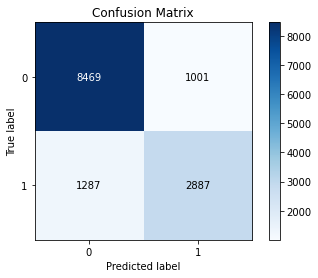

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, knn_pred)

**Classification Report**

In [ ]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.868081,0.742541,0.832307,0.805311,0.829676
recall,0.894298,0.691663,0.832307,0.792980,0.832307
f1-score,0.880994,0.716199,0.832307,0.798597,0.830580
support,9470.000000,4174.000000,0.832307,13644.000000,13644.000000


**ROC Curve**

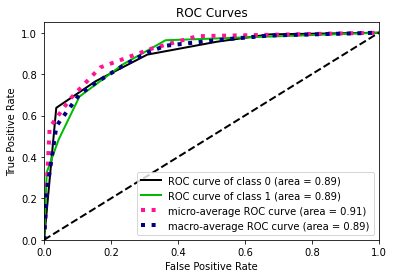

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba)

### Decision Tree Evaluation

**Confusion Matrix**

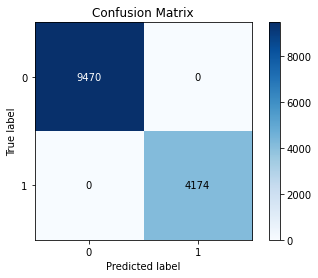

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, dtree_pred)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,9470.0,4174.0,1.0,13644.0,13644.0


**ROC Curve**

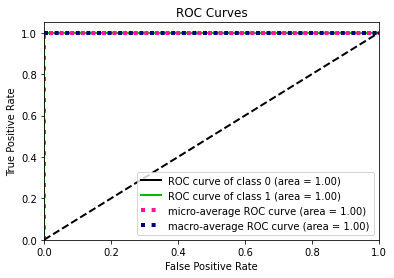

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba)

### Random Forest

**Confusion Matrix**

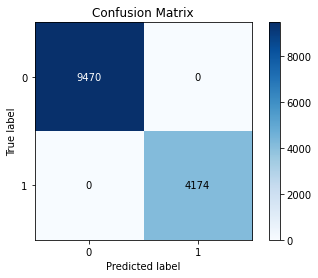

In [ ]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, rf_pred)

**Classification Report**

In [ ]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,9470.0,4174.0,1.0,13644.0,13644.0


**ROC Curve**

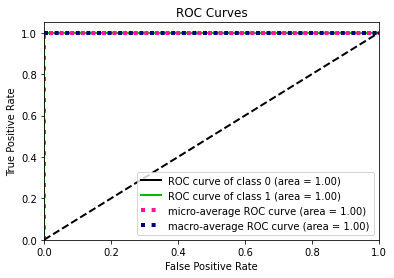

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba)

### SVM RBF

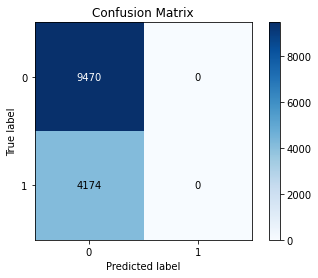

In [ ]:
# svm result
skplt.metrics.plot_confusion_matrix(y_test, svm_pred)

In [ ]:
#SVM prediction result
pd.DataFrame(metrics.classification_report(y_test, svm_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.694078,0.0,0.694078,0.347039,0.481744
recall,1.000000,0.0,0.694078,0.500000,0.694078
f1-score,0.819417,0.0,0.694078,0.409708,0.568739
support,9470.000000,4174.0,0.694078,13644.000000,13644.000000


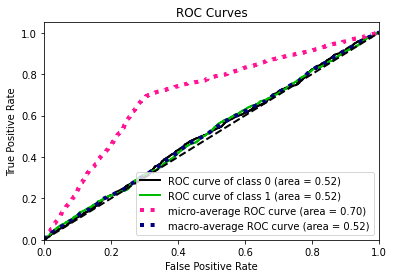

In [ ]:
# SVM perceptron result
skplt.metrics.plot_roc_curve(y_test, svm_pred_proba)

### XGBoost

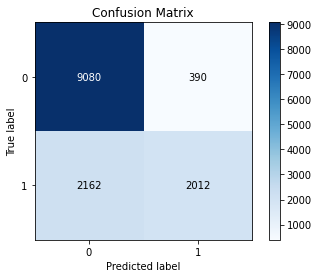

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, xgb_pred)

In [ ]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.807685,0.837635,0.812958,0.822660,0.816848
recall,0.958817,0.482032,0.812958,0.720424,0.812958
f1-score,0.876786,0.611922,0.812958,0.744354,0.795759
support,9470.000000,4174.000000,0.812958,13644.000000,13644.000000


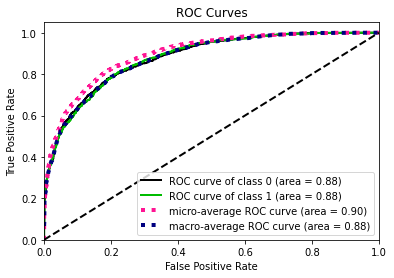

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba)

### Logistic Regression

**Confusion Matrix**

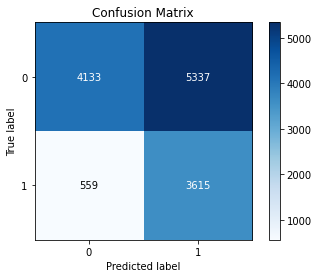

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, logreg_pred)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, logreg_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.880861,0.403820,0.567869,0.642341,0.734924
recall,0.436431,0.866076,0.567869,0.651253,0.567869
f1-score,0.583675,0.550815,0.567869,0.567245,0.573622
support,9470.000000,4174.000000,0.567869,13644.000000,13644.000000


**ROC Curve**

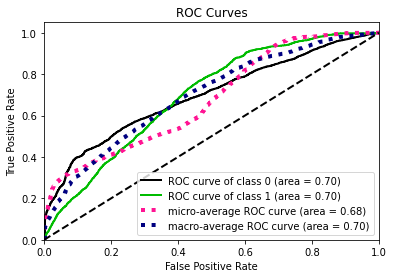

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, logreg_pred_proba)

-----

In [ ]:
# the function that prints all scores
def print_scores(headline, y_true, y_pred):
    print(headline)
    acc_score = accuracy_score(y_true, y_pred)
    print("accuracy: ",acc_score)
    pre_score = precision_score(y_true, y_pred)
    print("precision: ",pre_score)
    rec_score = recall_score(y_true, y_pred)                            
    print("recall: ",rec_score)
    f_score = f1_score(y_true, y_pred, average='weighted')
    print("f1_score: ",f_score)

In [ ]:
print_scores("========KNN=========;",y_test, knn_pred)
print('========================')
print_scores("=========Decision Tree=========;",y_test, dtree_pred)
print('========================')
print_scores("=========Random Forest=========;",y_test, rf_pred)
print('========================')
print_scores("=========SVM=========;",y_test, svm_pred)
print('========================')
print_scores("=========XGBoost=========;",y_test, xgb_pred)
print('========================')
print_scores("=========LogReg=========;",y_test, logreg_pred)

========KNN=========;
accuracy:  0.8323072412782175
precision:  0.7425411522633745
recall:  0.691662673694298
f1_score:  0.8305800579277614
=========Decision Tree=========;
accuracy:  1.0
precision:  1.0
recall:  1.0
f1_score:  1.0
=========Random Forest=========;
accuracy:  1.0
precision:  1.0
recall:  1.0
f1_score:  1.0
=========SVM=========;
accuracy:  0.6940779829961888
precision:  0.0
recall:  0.0
f1_score:  0.5687391623236053
=========XGBoost=========;
accuracy:  0.8129580768103195
precision:  0.8376353039134055
recall:  0.48203162434115954
f1_score:  0.7957585944790805


It can be seen that the results of the baseline model have many perfect values, this can be caused by overfitting the data because the data has several columns that are the same and the range of numbers is different, for that we can try to standardize it.

# Standradize Version

Standardization is used to change the range of existing data to be between 0 and 1 but does not change the actual data distribution. For machine learning model building, this standardization should be done on distance-based models like KNN and SVM, tree-based models will not be affected that much because the decision-making is only based on the tree

https://builtin.com/data-science/when-and-why-standardize-your-data 

In [ ]:
# df_train = pd.concat([X_train,y_train],axis=0).reset_index(drop=True) #merge by column axis = 1
# df_test = pd.concat([X_test,y_test],axis=0).reset_index(drop=True) #merge by column axis = 1

In [ ]:
column=X_train.columns
# churn_std = data.copy()
# #df_std sebagai dataset untuk clustering
# scale = StandardScaler()
# column_all = [x for x in column]
# for kolom in column_all:
#     churn_std[kolom] = scale.fit_transform(np.array(churn_std[kolom]).reshape(-1,1))

In [ ]:
column

Index(['age', 'source', 'quantity', 'price', 'browser', 'event_type',
       'frequency', 'total_spend', 'active_month', 'day', 'month', 'gender_F',
       'gender_M'],
      dtype='object')

In [ ]:
X_train.head()

,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,day,month,gender_F,gender_M
20784,67,16431,3,14.970000,24286,12207,3,241.439999,1,7900,6916,0,1
74470,56,5866,1,160.000000,24286,12273,1,129.990005,1,8269,8806,0,1
137095,15,22812,1,18.680000,2733,12207,1,25.000000,1,7663,10600,1,0
133216,12,6100,2,21.990000,24286,12207,2,24.000000,2,7403,10600,1,0
140162,44,22812,2,59.939999,12211,12207,4,139.810000,1,8034,10600,0,1


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns = column)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns = column)

In [ ]:
X_test_std.head()

,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,day,month,gender_F,gender_M
0,-1.192327,-1.420715,1.234449,-0.401274,1.031918,0.314823,-0.563664,-0.484126,-0.590491,-0.011957,-1.171352,1.013281,-1.013281
1,1.355822,0.054583,-0.698397,-0.401274,-0.648972,0.346840,-0.563664,-0.608878,-0.590491,-0.011957,0.252092,-0.986893,0.986893
2,1.416492,-1.388040,-0.698397,-0.569828,-0.575236,0.314823,-0.563664,-0.535020,-0.590491,0.802956,0.336909,1.013281,-1.013281
3,0.385098,-1.770095,2.200872,0.013615,-0.648972,0.314823,-0.563664,-0.458641,-0.590491,-0.011957,-0.009733,1.013281,-1.013281
4,0.385098,0.054583,-0.698397,-0.739394,-0.575236,0.346840,-0.221949,-0.285616,-0.590491,-1.442504,-0.009733,1.013281,-1.013281


In [ ]:
y_test.reset_index(drop=True)

,Churn
0,1
1,1
2,1
3,0
4,0
...,...
13639,0
13640,1
13641,1
13642,0


In [ ]:
X_train.head()

,age,source,quantity,price,browser,event_type,frequency,total_spend,active_month,day,month,gender_F,gender_M
20784,67,16431,3,14.970000,24286,12207,3,241.439999,1,7900,6916,0,1
74470,56,5866,1,160.000000,24286,12273,1,129.990005,1,8269,8806,0,1
137095,15,22812,1,18.680000,2733,12207,1,25.000000,1,7663,10600,1,0
133216,12,6100,2,21.990000,24286,12207,2,24.000000,2,7403,10600,1,0
140162,44,22812,2,59.939999,12211,12207,4,139.810000,1,8034,10600,0,1


In [ ]:
y_train.reset_index(drop=True)

,Churn
0,0
1,1
2,1
3,0
4,1
...,...
54568,1
54569,0
54570,0
54571,0


In [ ]:
# column=['recency','frequency' ,'total_spend','active_month']
# def plotting_boxplot(lst):
#     plt.figure(figsize=[len(lst)*5,4])
#     i = 1
#     for col in lst:
#         ax = plt.subplot(1,len(lst),i)
#         plt.hist(churn_std[col], color = '#458B74')
#         plt.title(col)
#         i = i+1
#     plt.show()
# plotting_boxplot(column)

## Modeling

**KNN**

In [ ]:
# define k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 5)

**Decision Tree**

In [ ]:
# define decision tree classifier
dtree = DecisionTreeClassifier()

**Random Forest**

In [ ]:
# define Random Forest classifier
rf = RandomForestClassifier()

**SVM RBF**

In [ ]:
svc_model = SVC(probability=True)

**XGBoost**

In [ ]:
# fit model no training data
xgb = XGBClassifier()

**LogReg**

In [ ]:
# fit model to data
logreg.fit(X_train, y_train)

## Fitting Model to Data

**KNN**

In [ ]:
# fit model to data
knn.fit(X_train_std, y_train)

**Decision Tree**

In [ ]:
# fit model to data
dtree.fit(X_train_std, y_train)

**Random Forest**

In [ ]:
# fit model to data
rf.fit(X_train_std, y_train)

**SVM RBF**

In [ ]:
# fit model to data
svc_model.fit(X_train_std, y_train)

**XGBoost**

In [ ]:
# fit model to data
xgb.fit(X_train_std, y_train)

**LogReg**

In [ ]:
# fit model to data
logreg.fit(X_train_std, y_train)

## Model Evaluation

In [ ]:
# knn prediction
knn_pred_std = knn.predict(X_test_std)
knn_pred_proba_std = knn.predict_proba(X_test_std)

# decision tree prediction
dtree_pred_std = dtree.predict(X_test_std)
dtree_pred_proba_std = dtree.predict_proba(X_test_std)

# random forest prediction
rf_pred_std = rf.predict(X_test_std)
rf_pred_proba_std = rf.predict_proba(X_test_std)

# SVM RBF prediction
svm_pred_std = svc_model.predict(X_test_std)
svm_pred_proba_std = svc_model.predict_proba(X_test_std)

# XGBoost prediction
xgb_pred_std = xgb.predict(X_test_std)
xgb_pred_proba_std = xgb.predict_proba(X_test_std)

# LogReg prediction
logreg_pred_std = logreg.predict(X_test_std)
logreg_pred_proba_std = logreg.predict_proba(X_test_std)


### KNN Evaluation

**Confusion Matrix**

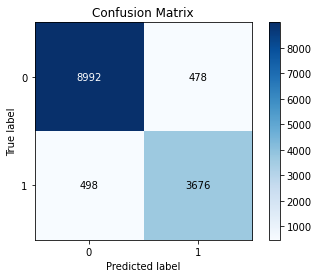

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, knn_pred_std)

**Classification Report**

In [ ]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred_std, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.947524,0.884930,0.928467,0.916227,0.928375
recall,0.949525,0.880690,0.928467,0.915107,0.928467
f1-score,0.948523,0.882805,0.928467,0.915664,0.928419
support,9470.000000,4174.000000,0.928467,13644.000000,13644.000000


**ROC Curve**

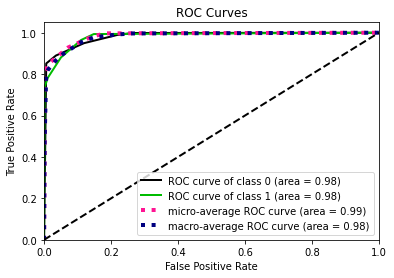

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba_std)

### Decision Tree

**Confusion Matrix**

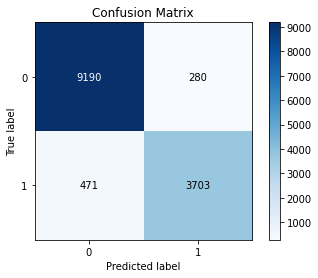

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, dtree_pred_std)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred_std, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.951247,0.929701,0.944957,0.940474,0.944656
recall,0.970433,0.887159,0.944957,0.928796,0.944957
f1-score,0.960744,0.907932,0.944957,0.934338,0.944588
support,9470.000000,4174.000000,0.944957,13644.000000,13644.000000


**ROC Curve**

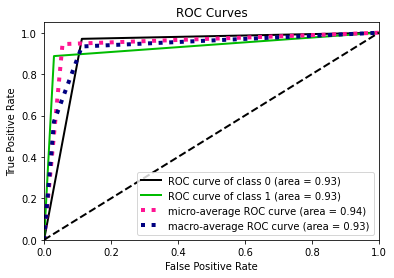

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba_std)

### Random Forest

**Confusion Matrix**

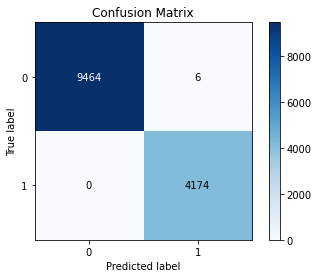

In [ ]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, rf_pred_std)

**Classification Report**

In [ ]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred_std, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.998565,0.99956,0.999282,0.999561
recall,0.999366,1.000000,0.99956,0.999683,0.999560
f1-score,0.999683,0.999282,0.99956,0.999482,0.999560
support,9470.000000,4174.000000,0.99956,13644.000000,13644.000000


**ROC Curve**

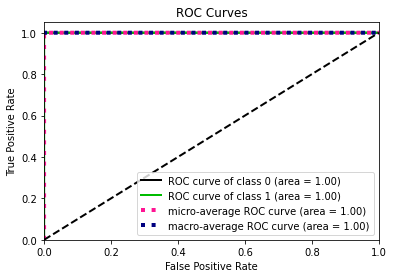

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba_std)

### XGBoost

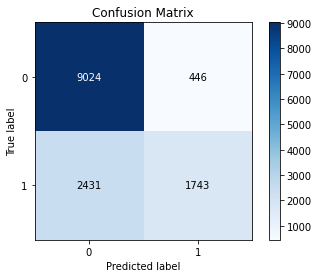

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, xgb_pred_std)

In [ ]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred_std, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.787778,0.796254,0.789138,0.792016,0.790371
recall,0.952904,0.417585,0.789138,0.685244,0.789138
f1-score,0.862509,0.547855,0.789138,0.705182,0.766249
support,9470.000000,4174.000000,0.789138,13644.000000,13644.000000


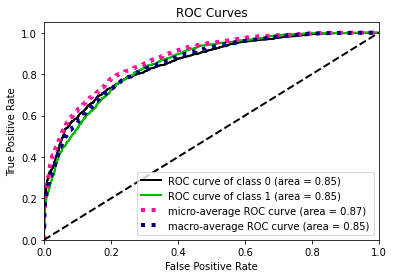

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba_std)

### Logistic Regression

**Confusion Matrix**

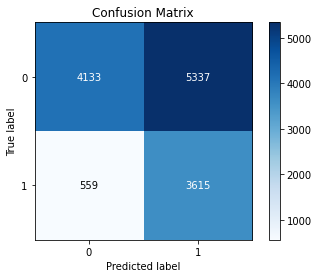

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, logreg_pred_std)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, logreg_pred_std, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.880861,0.403820,0.567869,0.642341,0.734924
recall,0.436431,0.866076,0.567869,0.651253,0.567869
f1-score,0.583675,0.550815,0.567869,0.567245,0.573622
support,9470.000000,4174.000000,0.567869,13644.000000,13644.000000


**ROC Curve**

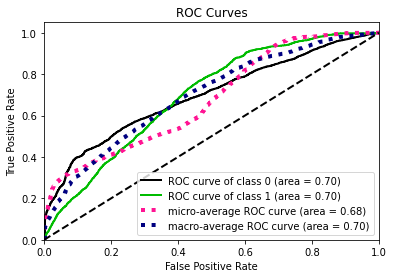

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, logreg_pred_proba_std)

-----

In [ ]:
# the function that prints all scores
def print_scores(headline, y_true_std, y_pred_std):
    print(headline)
    acc_score = accuracy_score(y_true_std, y_pred_std)
    print("accuracy: ",acc_score)
    pre_score = precision_score(y_true_std, y_pred_std)
    print("precision: ",pre_score)
    rec_score = recall_score(y_true_std, y_pred_std)                            
    print("recall: ",rec_score)
    f_score = f1_score(y_true_std, y_pred_std, average='weighted')
    print("f1_score: ",f_score)

In [ ]:
print_scores("========KNN=========;",y_test, knn_pred_std)
print('========================')
print_scores("=========Decision Tree=========;",y_test, dtree_pred_std)
print('========================')
print_scores("=========Random Forest=========;",y_test, rf_pred_std)
print('========================')
print_scores("=========XGBoost=========;",y_test, xgb_pred_std)
print('========================')
print_scores("=========Logreg=========;",y_test, logreg_pred_std)

========KNN=========;
accuracy:  0.9284667253004983
precision:  0.8849301877708233
recall:  0.8806899856252994
f1_score:  0.9284185589185326
=========Decision Tree=========;
accuracy:  0.9449574904720024
precision:  0.929701230228471
recall:  0.887158600862482
f1_score:  0.9445878339102839
=========Random Forest=========;
accuracy:  0.9995602462620933
precision:  0.9985645933014354
recall:  1.0
f1_score:  0.9995603345049618
=========SVM=========;
accuracy:  0.7801231310466139
precision:  0.7427626137303557
recall:  0.4302827024436991
f1_score:  0.7601653274345753
=========XGBoost=========;
accuracy:  0.7891380826737028
precision:  0.7962539972590224
recall:  0.4175850503114518
f1_score:  0.7662493206697656


# Under-Over Sampling

In [ ]:
from imblearn import under_sampling, over_sampling
# Undersampling
X_under, y_under = under_sampling.RandomUnderSampler().fit_resample(X_train_std, y_train)

# Overampling
X_over, y_over = over_sampling.RandomOverSampler().fit_resample(X_train_std, y_train)

#X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2,random_state =42)
#X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2,random_state =42)

## Define Model

**KNN**

In [ ]:
# define k-nearest neighbors classifier
knn_under = KNeighborsClassifier(n_neighbors = 5)
knn_over = KNeighborsClassifier(n_neighbors = 5)

**Decision Tree**

In [ ]:
# define decision tree classifier
dtree_under = DecisionTreeClassifier()
# define decision tree classifier
dtree_over = DecisionTreeClassifier()

**Random Forest**

In [ ]:
# define Random Forest classifier
rf_under = RandomForestClassifier()
rf_over = RandomForestClassifier()

**XGBoost**

In [ ]:
# define XgBoost classifier
xgb_under = XGBClassifier()
xgb_over = XGBClassifier()

**LogReg**

In [ ]:
# define LogReg classifier
logreg_under = LogisticRegression()
logreg_over = LogisticRegression()

## Fitting Model to Data

**KNN**

In [ ]:
# fit model to data
knn_under.fit(X_under, y_under)
# fit prediction model to data
y_pred_knn_under = knn_under.predict(X_test_std)

In [ ]:
# fit model to data
knn_over.fit(X_over, y_over)
# fit prediction model to data
y_pred_knn_over = knn_over.predict(X_test_std)

**Decision Tree**

In [ ]:
# fit model to data
dtree_under.fit(X_under, y_under)
# fit prediction model to data
y_pred_dtree_under = dtree.predict(X_test_std)

In [ ]:
# fit model to data
dtree_over.fit(X_over, y_over)
# fit prediction model to data
y_pred_dtree_over = dtree_over.predict(X_test_std)

**Random Forest**

In [ ]:
# fit model to data
rf_under.fit(X_under, y_under)
# fit prediction model to data
y_pred_rf_under = rf.predict(X_test_std)

In [ ]:
# fit model to data
rf_over.fit(X_over, y_over)
# fit prediction model to data
y_pred_rf_over = rf_over.predict(X_test_std)

**XGBoost**

In [ ]:
# fit model to data
xgb_under.fit(X_under, y_under)
# fit prediction model to data
y_pred_xgb_under = xgb_under.predict(X_test_std)

In [ ]:
# fit model to data
xgb_over.fit(X_over, y_over)
# fit prediction model to data
y_pred_xgb_over = xgb_over.predict(X_test_std)

**LogReg**

In [ ]:
# fit model to data
logreg_under.fit(X_under, y_under)
# fit prediction model to data
y_pred_logreg_under = logreg_under.predict(X_test_std)

In [ ]:
# fit model to data
logreg_over.fit(X_over, y_over)
# fit prediction model to data
y_pred_logreg_over = logreg_over.predict(X_test_std)

## Model Evaluation

In [ ]:
# knn prediction probability
knn_pred_proba_under = knn_under.predict_proba(X_test_std)
knn_pred_proba_over = knn_over.predict_proba(X_test_std)
# decision tree prediction probability

dtree_pred_proba_under = dtree_under.predict_proba(X_test_std)
dtree_pred_proba_over = dtree_over.predict_proba(X_test_std)

# random forest prediction probability
rf_pred_proba_under = rf_under.predict_proba(X_test_std)
rf_pred_proba_over = rf_over.predict_proba(X_test_std)


# XGBoost prediction probability
xgb_pred_proba_under = xgb_under.predict_proba(X_test_std)
xgb_pred_proba_over = xgb_over.predict_proba(X_test_std)

# LogReg prediction probability 
logreg_pred_proba_under = logreg_under.predict_proba(X_test_std)
logreg_pred_proba_over = logreg_over.predict_proba(X_test_std)

---

### KNN Evaluation

**Confusion Matrix**

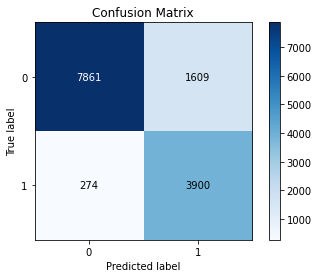

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_knn_under)

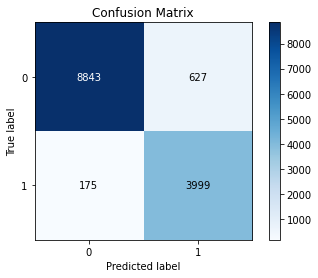

In [ ]:
#With Oversampling
skplt.metrics.plot_confusion_matrix(y_test, y_pred_knn_over)

**Classification Report**

In [ ]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, y_pred_knn_under, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.966318,0.707932,0.861991,0.837125,0.887272
recall,0.830095,0.934356,0.861991,0.882225,0.861991
f1-score,0.893042,0.805535,0.861991,0.849289,0.866272
support,9470.000000,4174.000000,0.861991,13644.000000,13644.000000


In [ ]:
# KNN prediction result Oversampling
pd.DataFrame(metrics.classification_report(y_test, y_pred_knn_over, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.980594,0.864462,0.94122,0.922528,0.945067
recall,0.933791,0.958074,0.94122,0.945932,0.941220
f1-score,0.956621,0.908864,0.94122,0.932742,0.942011
support,9470.000000,4174.000000,0.94122,13644.000000,13644.000000


**ROC Curve**

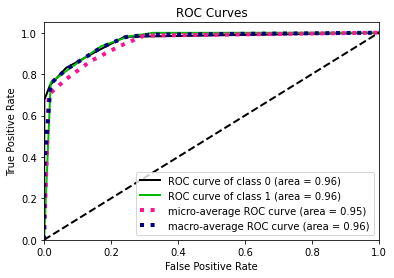

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba_under)

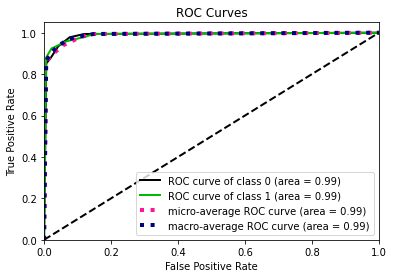

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba_over)

### Decision Tree

**Confusion Matrix**

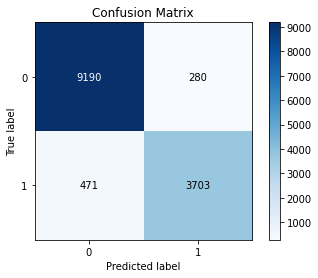

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dtree_under)

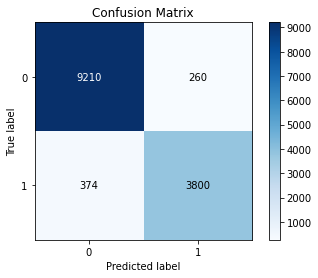

In [ ]:
# Decision Tree result Oversampling
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dtree_over)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, y_pred_dtree_under, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.951247,0.929701,0.944957,0.940474,0.944656
recall,0.970433,0.887159,0.944957,0.928796,0.944957
f1-score,0.960744,0.907932,0.944957,0.934338,0.944588
support,9470.000000,4174.000000,0.944957,13644.000000,13644.000000


In [ ]:
# Decision Tree prediction result Oversampling
pd.DataFrame(metrics.classification_report(y_test, y_pred_dtree_over, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.960977,0.935961,0.953533,0.948469,0.953324
recall,0.972545,0.910398,0.953533,0.941471,0.953533
f1-score,0.966726,0.923002,0.953533,0.944864,0.953350
support,9470.000000,4174.000000,0.953533,13644.000000,13644.000000


**ROC Curve**

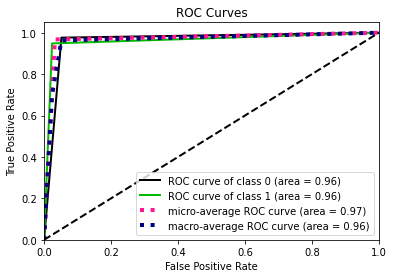

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba_under)

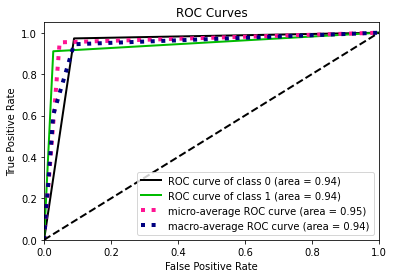

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba_over)

### Random Forest

**Confusion Matrix**

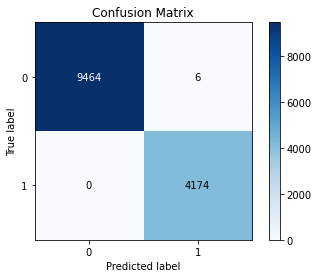

In [ ]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf_under)

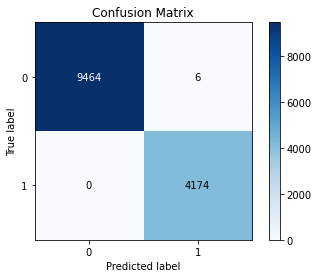

In [ ]:
# random forest result Oversampling
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf_over)

**Classification Report**

In [ ]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, y_pred_rf_under, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.998565,0.99956,0.999282,0.999561
recall,0.999366,1.000000,0.99956,0.999683,0.999560
f1-score,0.999683,0.999282,0.99956,0.999482,0.999560
support,9470.000000,4174.000000,0.99956,13644.000000,13644.000000


In [ ]:
# random forest prediction result Oversampling
pd.DataFrame(metrics.classification_report(y_test, y_pred_rf_over, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.998565,0.99956,0.999282,0.999561
recall,0.999366,1.000000,0.99956,0.999683,0.999560
f1-score,0.999683,0.999282,0.99956,0.999482,0.999560
support,9470.000000,4174.000000,0.99956,13644.000000,13644.000000


**ROC Curve**

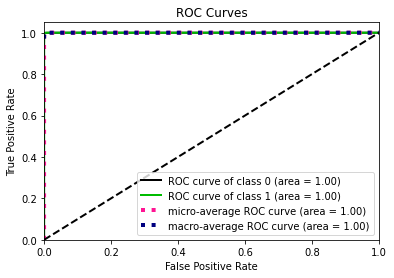

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba_under)

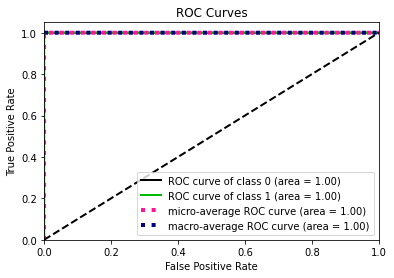

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba_over)

### XGBoost

**Confussion Matrix**

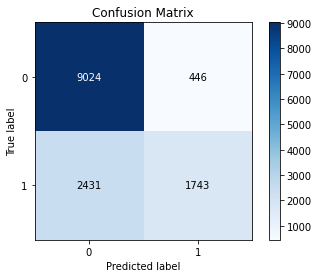

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb_under)

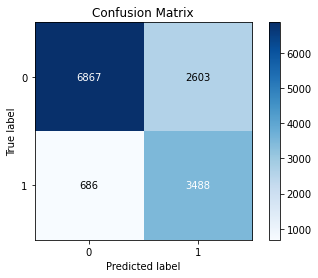

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb_over)

**Classsification Report**

In [ ]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, y_pred_xgb_under, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.787778,0.796254,0.789138,0.792016,0.790371
recall,0.952904,0.417585,0.789138,0.685244,0.789138
f1-score,0.862509,0.547855,0.789138,0.705182,0.766249
support,9470.000000,4174.000000,0.789138,13644.000000,13644.000000


In [ ]:
# XGBoost prediction result Oversampling
pd.DataFrame(metrics.classification_report(y_test, y_pred_xgb_over, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.909175,0.572648,0.758942,0.740912,0.806224
recall,0.725132,0.835649,0.758942,0.780391,0.758942
f1-score,0.806791,0.679591,0.758942,0.743191,0.767878
support,9470.000000,4174.000000,0.758942,13644.000000,13644.000000


**ROC-AUC**

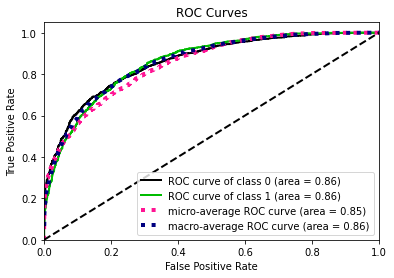

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba_under)

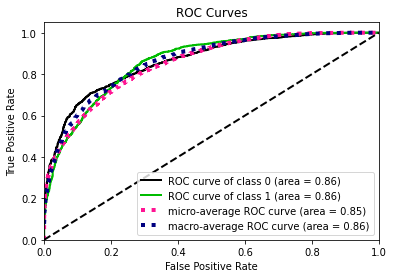

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba_over)

### Logistic Regression

**Confusion Matrix**

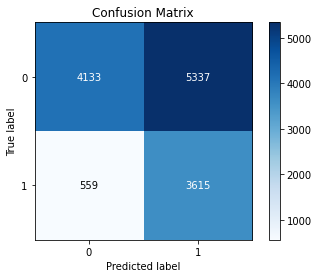

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, y_pred_logreg_under)

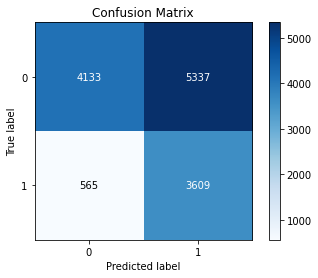

In [ ]:
# Decision Tree result Oversampling
skplt.metrics.plot_confusion_matrix(y_test, y_pred_logreg_over)

**Classification Report**

In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, y_pred_logreg_under, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.880861,0.403820,0.567869,0.642341,0.734924
recall,0.436431,0.866076,0.567869,0.651253,0.567869
f1-score,0.583675,0.550815,0.567869,0.567245,0.573622
support,9470.000000,4174.000000,0.567869,13644.000000,13644.000000


In [ ]:
# Decision Tree prediction result Oversampling
pd.DataFrame(metrics.classification_report(y_test, y_pred_logreg_over, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.879736,0.403421,0.567429,0.641578,0.734021
recall,0.436431,0.864638,0.567429,0.650535,0.567429
f1-score,0.583427,0.550152,0.567429,0.566790,0.573248
support,9470.000000,4174.000000,0.567429,13644.000000,13644.000000


**ROC Curve**

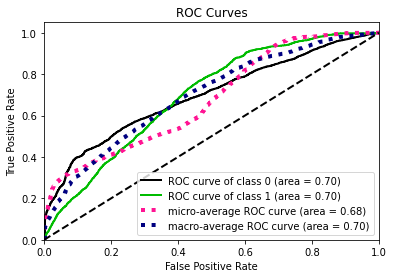

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, logreg_pred_proba_under)

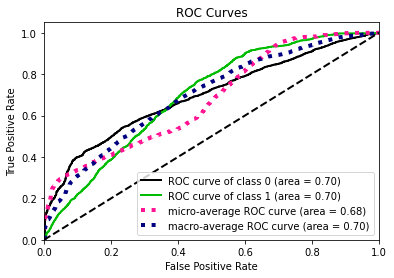

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, logreg_pred_proba_over)

### All Score

In [ ]:
# the function that prints all scores
def print_scores(headline, y_true, y_pred):
    print(headline)
    acc_score = accuracy_score(y_true, y_pred)
    print("accuracy: ",acc_score)
    pre_score = precision_score(y_true, y_pred)
    print("precision: ",pre_score)
    rec_score = recall_score(y_true, y_pred)                            
    print("recall: ",rec_score)
    f_score = f1_score(y_true, y_pred, average='weighted')
    print("f1_score: ",f_score)

In [ ]:
print_scores("========KNN Undersampling Data Test=========;",y_test, y_pred_knn_under)
print('========================')
print_scores("=========Decision Tree Undersampling Data Test=========;",y_test, y_pred_dtree_under)
print('========================')
print_scores("=========Random Forest Undersampling Data Test=========;",y_test, y_pred_rf_under)
print('========================')
print_scores("=========XGBoost Undersampling Data Test=========;",y_test, y_pred_xgb_under)
print('========================')
print_scores("=========Logreg Undersampling Data Test=========;",y_test, y_pred_logreg_under)

========KNN Undersampling Data Test=========;
accuracy:  0.8619906185869246
precision:  0.7079324741332366
recall:  0.934355534259703
f1_score:  0.8662716533667384
=========Decision Tree Undersampling Data Test=========;
accuracy:  0.9449574904720024
precision:  0.929701230228471
recall:  0.887158600862482
f1_score:  0.9445878339102839
=========Random Forest Undersampling Data Test=========;
accuracy:  0.9995602462620933
precision:  0.9985645933014354
recall:  1.0
f1_score:  0.9995603345049618
=========SVM Undersampling Data Test=========;
accuracy:  0.7801231310466139
precision:  0.7427626137303557
recall:  0.4302827024436991
f1_score:  0.7601653274345753
=========XGBoost Undersampling Data Test=========;
accuracy:  0.7891380826737028
precision:  0.7962539972590224
recall:  0.4175850503114518
f1_score:  0.7662493206697656
=========Logreg Undersampling Data Test=========;
accuracy:  0.5678686602169452
precision:  0.40382037533512066
recall:  0.8660757067561092
f1_score:  0.573622194156

In [ ]:
print_scores("========KNN Oversampling Data Test=========;",y_test, y_pred_knn_over)
print('========================')
print_scores("=========Decision Tree Oversampling Data Test=========;",y_test, y_pred_dtree_over)
print('========================')
print_scores("=========Random Forest Oversampling Data Test=========;",y_test, y_pred_rf_over)
print('========================')
print_scores("=========SVM Oversampling Data Test=========;",y_test, y_pred_svc_over)
print('========================')
print_scores("=========XGBoost Oversampling Data Test=========;",y_test, y_pred_xgb_over)
print('========================')
print_scores("=========Logreg Oversampling Data Test=========;",y_test, y_pred_logreg_over)

========KNN Oversampling Data Test=========;
accuracy:  0.9412195836997947
precision:  0.8644617380025941
recall:  0.9580737901293723
f1_score:  0.9420106313088356
=========Decision Tree Oversampling Data Test=========;
accuracy:  0.9535326883611844
precision:  0.9359605911330049
recall:  0.9103977000479156
f1_score:  0.953350024497293
=========Random Forest Oversampling Data Test=========;
accuracy:  0.9995602462620933
precision:  0.9985645933014354
recall:  1.0
f1_score:  0.9995603345049618
=========SVM Oversampling Data Test=========;
accuracy:  0.7260334212840809
precision:  0.5313578826237054
recall:  0.8850023957834212
f1_score:  0.736690824453586
=========XGBoost Oversampling Data Test=========;
accuracy:  0.7589416593374377
precision:  0.572648169430307
recall:  0.8356492573071395
f1_score:  0.7678775411181396
=========Logreg Oversampling Data Test=========;
accuracy:  0.5674289064790384
precision:  0.403420523138833
recall:  0.864638236703402
f1_score:  0.5732478860593306


**which is the best model?**

After observing, it is true that the results of the standardized data produce a much better model, but because so much data has several columns that have the same value in several rows, this will slightly cause a bias that the model is easier to predict, so the model with Under Sampling will be selected.

**why not Over Sampling?**

indeed the results of over sampling are quite good, but it should be noted that over sampling will basically create additional synthetic data based on the data we have, while under sampling will delete some data in the train data randomly, you can see the difference, over sampling will add new synthetic data, while under sampling will delete some of our original train data. because I think I don't know how the synthesized data is, it will be safe to use undersampling only which is certainly our original train data.


**Which model is the best?**

in this case there are several evaluation metrics to consider, namely precision, recall, and roc.The models with the best evaluation metrics are knn_under and dtree_under.

**then which one is the best?**

In this case, the roc values of knn and dtree are quite similar, so we need to compare their recall and precision values.
knn has a much higher recall value than dtree, but dtree has a higher precision value than knn.

Please note that:

- Precision = Of all the users that the algorithm predicts will churn, how many of them do actually churn?
- Recall = What percentage of users that end up churning does the algorithm successfully find?

As you can see, both precision and recall are important for evaluating the performance of a churn prediction algorithm.

The precision will see how many people actually churn((TP) / (TP + FP)), while the recall will also see who the people who were predicted positive but turned out not to be (TP) / (TP + FN).
Furthermore, it depends on the company's policy

if the company has thought about how much money the customer will spend from customers who are churned but not detected churn, the company needs to look at recall for the model evaluation matrix. 

# Business Evaluation

## Lift Curve

**KNN**

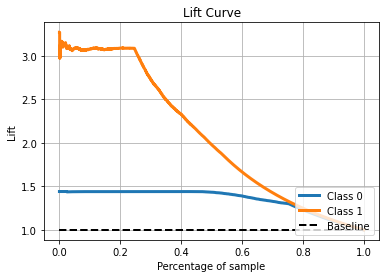

In [ ]:
skplt.metrics.plot_lift_curve(y_test, knn_pred_proba_under)

**Implementation**

if we took around 40% of samples, knn model's performance is 3.2 times better to predict the customer Churn than wihtout using model or random choice

**Dtree**

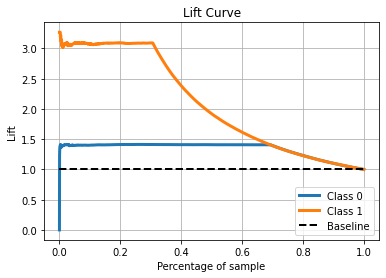

In [ ]:
skplt.metrics.plot_lift_curve(y_test, dtree_pred_proba_under)

**Implementation**



if we took around 40% of samples, decision tree model's performance is 3.1 times better to predict the customer Churn than wihtout using model or random choice

## **Cummulative Gain Curve**

**KNN**

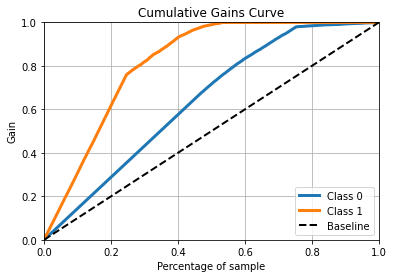

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, knn_pred_proba_under)

**Implementation**

if we took 40% of samples, then approximately our model can take around 93% of the actual target class in the data that we can get instead of using random choice which is only 40%

**Dtree**

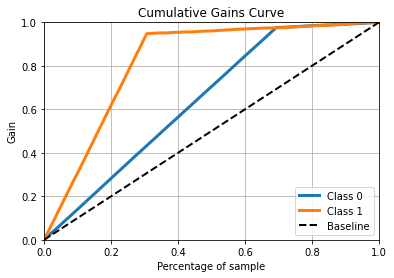

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, dtree_pred_proba_under)

**Implementation**




if we took 40% of samples, then approximately our model can take around 96% of the actual target class in the data that we can get instead of using random choice which is only 40%

## Cost Benefit

the `cost benefit` matrix shows the cost that we should spend to treat the churned customer and how many we can loss from the customer that we not predict to be churn but actualy they are churned depends on the confusion matrix of the best model.

let's say the company needs to spend 5$ per each customer to treat them to not churn in just 3 month

but if there are customers that we predict not churn but actually they are churned, we will lose about 10$ per customer

**knn**

In [ ]:
# create cost benefit matrix
costbenefit_mat_knn = np.array([[0, -5*3],
                            [-10*3, - 5*3]])

In [ ]:
costbenefit_mat_knn

array([[  0, -30],
       [-15, -15]])

In [ ]:
# check model confusion matrix
metrics.confusion_matrix(y_test, y_pred_knn_under)

array([[7861, 1609],
       [ 274, 3900]])

In [ ]:
# cross benefit and metrix model
cost_knn = np.array([[0*7861, -15*1690],
                    [-30*274, - 15*3900]])
cost_knn

array([[     0, -50700],
       [ -4110, -58500]])

In [ ]:
-50700-4110-58500

-113310

for total 3 months, if we using the knn model, we will loss 50700 dollar for lossing customer, and 62610 dollar to cost reactivated the churn customer

**Dtree**

In [ ]:
# create cost benefit matrix
costbenefit_mat_dtree = np.array([[0, -5*3],
                            [-10*3, -5*3]])

In [ ]:
costbenefit_mat_dtree

array([[  0, -30],
       [-15, -15]])

In [ ]:
# check model confusion matrix
metrics.confusion_matrix(y_test, y_pred_dtree_under)

array([[9190,  280],
       [ 471, 3703]])

In [ ]:
# cross benefit and metrix model
cost_dtree = np.array([[0*9190, -15*280],
                      [-30*471, - 15*3703]])
cost_dtree

array([[     0,  -8400],
       [ -7065, -55545]])

In [ ]:
-8400-7065-55545

-71010

for total 3 months, if we using the dtree model, we will loss 8400 dollar for lossing customer, and 62610 dollar to cost reactivated churn customer

## Simulation

In [ ]:
grouped = df_churn.groupby(by='Churn').size()
grouped

Churn
0    47346
1    20871
dtype: int64

We have 20871 population of 1(positive Churn) so we use this to be our population in the business simulation because we just focusing on the Churn customer

*formula

- saved : population*treat * prediction
- failed : treat - saved
- profit : (cost + cost*margin rate) * saved
- netto : profit - total cost

---------

**If we took 40% of the sample** 

based on cumulative gain plot

### KNN

- Population : 20871 -> total sample : 8348
- Treat : 40%
- Model : 93%
- Random Choice(without model) : 40%
- cost : 5$
- margin rate : 5%



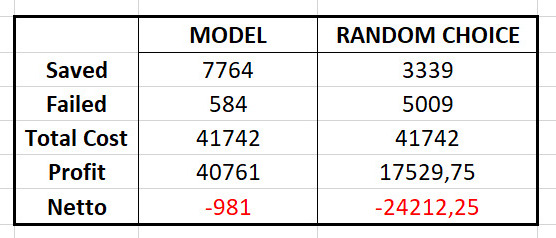

Loss 981 dollar if we're using the model and loss 24.212,25 dollar without using the model

### Dtree

- Population : 20871 -> total sample: 8348
- Treat : 40%
- Model : 96%
- Random Choice(without model) : 40%
- cost : 5$
- margin rate : 5%

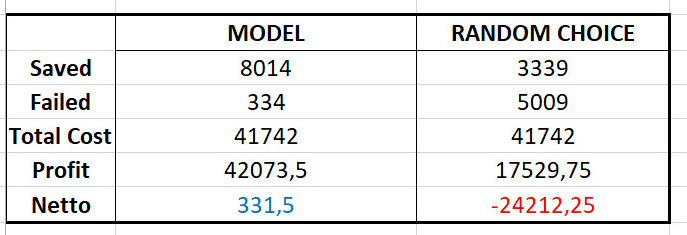

we will get 331,5 dollar nett profit if we using the model & loss about 24.212,25 dollar without using model/random choice

## Best Variabel to Predict

In [ ]:
# let's create a dictionary of features importance values
feature_dict= {}
for col, val in sorted(zip(list(X_under), dtree_under.feature_importances_),key=lambda x:x[1],reverse=True):
  feature_dict[col]=val

In [ ]:
dtree_df = pd.DataFrame({'Feature':feature_dict.keys(),'Importance':feature_dict.values()})
dtree_df

,Feature,Importance
0,total_spend,0.336568
1,age,0.216077
2,active_month,0.126781
3,month,0.072206
4,day,0.069062
5,price,0.062501
6,frequency,0.050435
7,quantity,0.028073
8,gender_F,0.020065
9,gender_M,0.009244


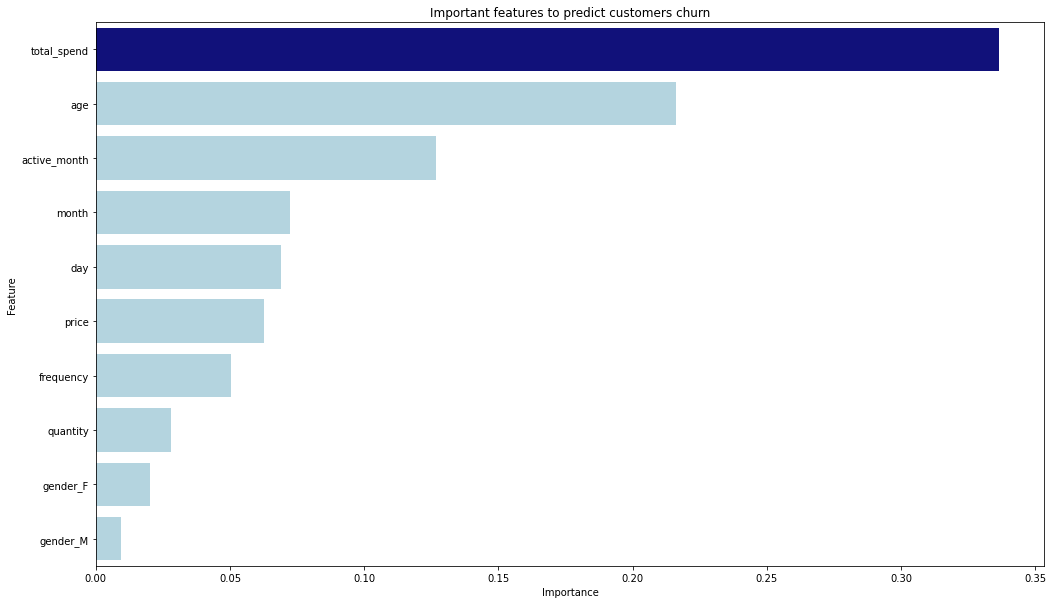

In [ ]:
values = dtree_df.head(10).Importance    
idx = dtree_df.head(10).Feature
plt.figure(figsize=(17,10))
clrs = ['lightblue' if (x < max(values)) else 'darkblue' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict customers churn')
plt.show()

----------

----------------